# Data Exploration
In this notebook, I will analyze the provided data files.

## Provided Datasets
The competition provides 6 CSV files: shops.csv, item_categories.csv, items.csv, sales_train_v2.csv, test.csv and sample_submission.csv.  The last file does not require analysis.

### Cross-reference files
There are three files that map the id of an entity (shop, item category, item) to its name.  In the case of items, there is also a mapping of the item to its category.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

shops = pd.read_csv('data/provided/shops.csv', index_col=1)
print('number of shops:', len(shops))
shops.head()

number of shops: 60


,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""


In [2]:
categs = pd.read_csv('data/provided/item_categories.csv', index_col=1)
print('number of categories:', len(categs))
categs.head()

number of categories: 84


,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


In [3]:
items = pd.read_csv('data/provided/items.csv', index_col=1)
print('number of items:', len(items))
items.head()

number of items: 22170


,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


### Transactions file
The file called sales_train_v2.csv is the most useful file.  Each record in it is a quantity change for a product (item) at a shop on a particular date.  There's a field called date_block_num which is a label for a particular year and month combination.  Let's do some general analysis of its content.

In [4]:
transactions = pd.read_csv('data/provided/sales_train_v2.csv')
print('number of records:', len(transactions))
transactions.head()

number of records: 2935849


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
print('max date_block_num:', transactions['date_block_num'].max())
block_counts = transactions.groupby(['date_block_num'],as_index=True)[['item_cnt_day']].count()
block_counts.head(34)

max date_block_num: 33


,item_cnt_day
date_block_num,
0,115690
1,108613
2,121347
3,94109
4,91759
5,100403
6,100548
7,104772
8,96137


There are 34 months of data.  As well, while there are at least 50000 records for each month, there appears to be more data for the earlier months.   

In [6]:
print('number of records with zero counts:', len(transactions.loc[transactions['item_cnt_day'] == 0.0]))
transactions['item_cnt_day'].describe()

number of records with zero counts: 0


count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

Each record seems to be a valid one because there are no records where the count is zero.  However, the minimum value for the count is -22.  This suggests that the count is for net sales (sales - returns).  The maximum value is 2169 and the mean is just 1.24 suggesting a distribution that is right skewed. 

### Test file
This file lists the predictions we have to make for the 35th month (date_block_num=34).

In [7]:
test_data = pd.read_csv('data/provided/test.csv', index_col=0)
print("number of predictions to make:", len(test_data))
test_data.head()

number of predictions to make: 214200


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


## Data Analysis
Let's aggregate the daily records so we can have a look at the distribution of the monthly counts for each item and shop pairing.

In [8]:
#aggregate by date, shop, item
monthly_totals = transactions.groupby(['date_block_num', 'shop_id', 'item_id'],as_index=False)[['item_cnt_day']].sum()

print("Number of monthly sales count records:", len(monthly_totals))
monthly_totals['item_cnt_day'].describe()

Number of monthly sales count records: 1609124


count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_day, dtype: float64

After aggregation, the number of records reduced to slightly over 50% of the original number of records.  Let's see how many monthly records have a negative value in the item_cnt_day field.

In [9]:
zero_counts = monthly_totals.loc[monthly_totals['item_cnt_day'] == 0.0]
print("number of records with a zero sales count:", len(zero_counts))

negative_counts = monthly_totals.loc[monthly_totals['item_cnt_day'] < 0.0]['item_cnt_day']
negative_counts.describe()

number of records with a zero sales count: 2583


count    915.000000
mean      -1.080874
std        0.852346
min      -22.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       -1.000000
Name: item_cnt_day, dtype: float64

Of the 1609124 monthly sales count records, 0.16% of them have a negative count value.

### Correlation between sales among months
Let's look at how related are the sales counts for a base month and the months prior to it.

In [10]:
# this is a helper function to append the monthly sales count from a prior month

# return a copy of the monthly totals with the date_block_num shifted by an index
def get_shifted_monthly_totals(df, month_idx):
    totals = df.copy()
    totals['date_block_num'] = totals['date_block_num'] - month_idx
    return totals

In [11]:
# rename the count field to t for easier comparison
item_sales_data = monthly_totals.copy()
item_sales_data.rename(index=str, columns={"item_cnt_day":"t"}, inplace=True)
item_sales_data.head()

,date_block_num,shop_id,item_id,t
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [12]:
# use the helper function above to add the sales counts for the previous 12 months for each record
for n in range(-1, -13, -1):
    prior_totals = get_shifted_monthly_totals(monthly_totals, n)
    item_sales_data = item_sales_data.merge(prior_totals, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    item_sales_data.rename(index=str, columns={"item_cnt_day":"t" + str(n) }, inplace=True)
    
item_sales_data.head()

,date_block_num,shop_id,item_id,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
0,0,0,32,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
item_diff_data = item_sales_data.copy()

# all records for the year 2013 do not have a valid value for t-12 (because we don't have records for 2012) 
# so we remove them from the analysis
item_diff_data = item_diff_data.loc[(item_diff_data['date_block_num'] > 11)]

# substitute a 0 for when we do not have data for a prior month
item_diff_data.fillna(0.0, inplace=True)

Now, let's look at the relationship between the sales count of a base month (t) and:
* its prior month (t-1)
* two months ago (t-2)
* three months ago (t-3)
* six months ago (t-6)
* a year ago (t-12)

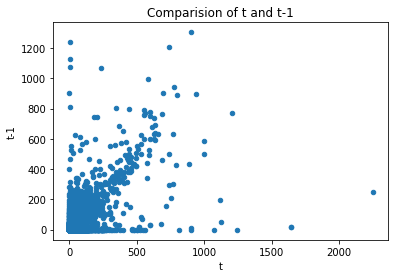

In [14]:
item_diff_data.plot.scatter(x='t', y='t-1', title="Comparision of t and t-1")

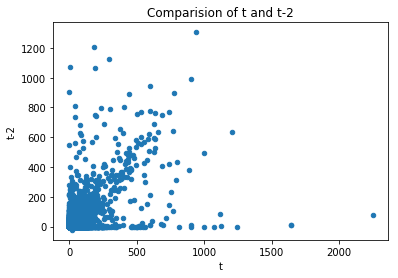

In [15]:
item_diff_data.plot.scatter(x='t', y='t-2', title="Comparision of t and t-2")

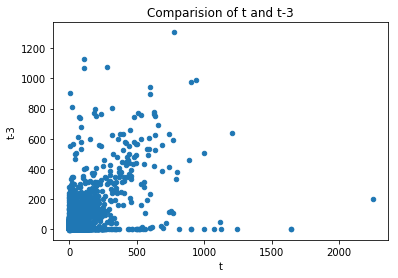

In [16]:
item_diff_data.plot.scatter(x='t', y='t-3', title="Comparision of t and t-3")

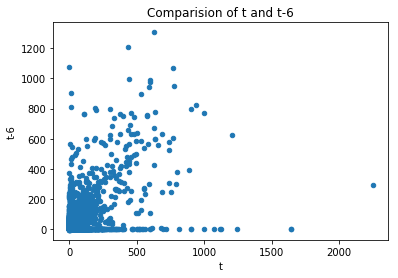

In [17]:
item_diff_data.plot.scatter(x='t', y='t-6', title="Comparision of t and t-6")

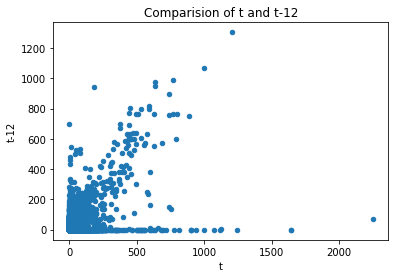

In [18]:
item_diff_data.plot.scatter(x='t', y='t-12', title="Comparision of t and t-12")

Above a certain value, it looks like there is some correction between the sales count in the base month and the other month.

### Shops

Let's aggregate the monthly sales count by shop and analyze the data.

In [19]:
# aggregate by month and shop
monthly_shop_totals = monthly_totals.groupby(['date_block_num', 'shop_id'],as_index=False)[['item_cnt_day']].sum()
monthly_shop_totals.head()

,date_block_num,shop_id,item_cnt_day
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1146.0
3,0,3,767.0
4,0,4,2114.0


In [20]:
monthly_shop_totals['item_cnt_day'].describe()

count     1586.00000
mean      2300.25599
std       1906.64723
min         -1.00000
25%       1185.25000
50%       1737.50000
75%       2599.00000
max      16318.00000
Name: item_cnt_day, dtype: float64

Interesting.  There is one shop that had a monthly net sales amount of -1.  Let's try to see if we can cluster the shops so we can use the cluster instead of the shop_id in the training data.

In [21]:
shop_totals_all_months = monthly_shop_totals.pivot(index='shop_id', columns='date_block_num', values='item_cnt_day')
shop_totals_all_months.fillna(0.0, inplace=True)
shop_totals_all_months.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2947.0,3364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,795.0,...,987.0,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0,727.0
3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,793.0,...,977.0,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0,613.0
4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,1482.0,...,1188.0,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0,831.0


In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# use GMM to attempt to exract n clusters from the data
def get_clusterer(data, n):
    clusterer = GaussianMixture(n_components=n)
    clusterer.fit(data)
    
    # extract predictions for the clusters
    preds = clusterer.predict(data)
    centers = clusterer.means_
    
    # determine the strength of the clusters
    score = silhouette_score(data, preds)
    print("n={}: score: {}".format(n, score))
    
    return clusterer, score, preds 

In [23]:
from sklearn.preprocessing import StandardScaler

# scale the monthly sales count for the shops
scaler = StandardScaler()
scaler.fit(shop_totals_all_months)
scaled_shop_data = scaler.transform(shop_totals_all_months)

# try to find good groupings for a range for the number of clusters
for n in range(2, 12):   
    get_clusterer(shop_totals_all_months, n)

n=2: score: 0.6829974850566602
n=3: score: 0.4494084245697172
n=4: score: 0.4559082285641126
n=5: score: 0.2786260665655067
n=6: score: 0.4489711167704321
n=7: score: 0.44080288041653565
n=8: score: 0.18945234614339812
n=9: score: 0.2491475313950096
n=10: score: 0.24951505027018292
n=11: score: 0.22153029142703315


It looks like we can't group the shops in any meaningful way.  Let's examine the total sales of all shops by month.

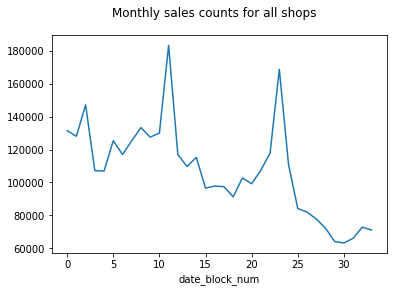

In [24]:
#plot sales by month to see any cyclical sales pattern
shop_totals_all_months.sum(axis=0).plot.line()
plt.suptitle('Monthly sales counts for all shops')
plt.show()

It looks like a clearly downward trend.  Do all the shops follow this trend?  Let's look at the monthly sales count for some sample shops.

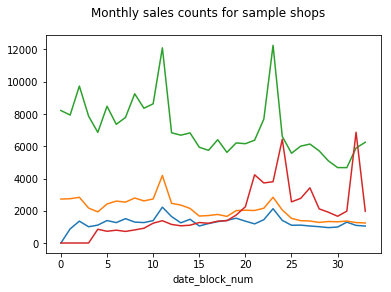

In [25]:
shop_totals_all_months.loc[5].plot.line()
shop_totals_all_months.loc[15].plot.line()
shop_totals_all_months.loc[25].plot.line()
shop_totals_all_months.loc[55].plot.line()
plt.suptitle('Monthly sales counts for sample shops')
plt.show()

### Categories

Now, let's aggregate monthly sales count for categories across all shops.  Let's see if we can classify the categories into different types so we can use the type (and not the item_category_id id) in the training data.

In [26]:
# merge in the respective item_category_id for the item in the monthly sales counts for items
monthly_categ_totals = monthly_totals.merge(items, on=['item_id'], how='left').drop(['item_name'], axis=1)

# aggregate by category and month
monthly_categ_totals = monthly_categ_totals.groupby(['date_block_num', 'item_category_id'],as_index=False)[['item_cnt_day']].sum()
monthly_categ_totals.head()

,date_block_num,item_category_id,item_cnt_day
0,0,0,1.0
1,0,1,1.0
2,0,2,1390.0
3,0,3,440.0
4,0,4,251.0


In [27]:
monthly_categ_totals['item_cnt_day'].describe()

count     2077.000000
mean      1756.478575
std       3669.113351
min         -1.000000
25%        145.000000
50%        514.000000
75%       1323.000000
max      36277.000000
Name: item_cnt_day, dtype: float64

In [28]:
categ_totals_all_months = monthly_categ_totals.pivot(index='item_category_id', columns='date_block_num', values='item_cnt_day')
categ_totals_all_months.fillna(0.0, inplace=True)
categ_totals_all_months.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
item_category_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,790.0,...,370.0,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0,82.0
3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,391.0,...,1398.0,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0,1059.0
4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,89.0,...,10.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0


In [29]:
# this helper function appends sums for each quarter from Q1 2013 to Q4 2015 
# it depends on the date_block_num value passed in and it assumes that date_block_num won't be larger than 36
def get_quarterly_counts(totals, date_block_num):
    yr_label = '2013'
    qtr_label = 'q1'
    for x in range(0, date_block_num, 3):
        if x >= 24:
            yr_label = '2015'
        elif x >= 12:
            yr_label = '2014'
        
        if (x % 12) < 3:
            qtr_label = 'q1'
        elif (x % 12) <6:
            qtr_label = 'q2'
        elif (x % 12) <9:
            qtr_label = 'q3'
        else:
            qtr_label = 'q4'

        lbl = yr_label + qtr_label
        totals[lbl] = totals[x] + totals[x+1] + totals[x+2]

In [30]:
#sum up quarterly totals Q1 2013 to Q3 2015
get_quarterly_counts(categ_totals_all_months, 33)
categ_totals_all_qtrs = categ_totals_all_months[['2013q1','2013q2','2013q3','2013q4','2014q1','2014q2','2014q3','2014q4','2015q1','2015q2','2015q3']]
categ_totals_all_qtrs.head()

date_block_num,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
item_category_id,,,,,,,,,,,
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3605.0,1909.0,2084.0,3741.0,2726.0,1439.0,1048.0,1302.0,906.0,420.0,335.0
3,1035.0,498.0,916.0,4139.0,4229.0,2240.0,3337.0,4709.0,3005.0,1972.0,2668.0
4,697.0,511.0,405.0,284.0,200.0,132.0,102.0,56.0,14.0,5.0,1.0


Let's see if we can use quarterly sales count for the categories to extract types for them.

In [31]:
scaler.fit(categ_totals_all_qtrs)
scaled_data = scaler.transform(categ_totals_all_qtrs)

for n in range(2, 12):
    get_clusterer(scaled_data, n)

n=2: score: 0.834948726916834
n=3: score: 0.8179327236122127
n=4: score: 0.3719447874627149
n=5: score: 0.8012466021513218
n=6: score: 0.34270101967961974
n=7: score: 0.35866714812475364
n=8: score: 0.38735911750990326
n=9: score: 0.41864013759762125
n=10: score: 0.32897008802169864
n=11: score: 0.40087584391464626


The silhouette score for when the number of clusters is 4 is somewhat high.  Let's see how valid the clusters are.

In [32]:
clusterer, score, preds = get_clusterer(scaled_data, 4)

categ_clusters = pd.DataFrame(preds, columns=['categ_type'])
categ_types = pd.concat([categ_clusters, categ_totals_all_qtrs], axis=1)
categ_types.head(10)

n=4: score: 0.8138174504099983


,categ_type,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3605.0,1909.0,2084.0,3741.0,2726.0,1439.0,1048.0,1302.0,906.0,420.0,335.0
3,2,1035.0,498.0,916.0,4139.0,4229.0,2240.0,3337.0,4709.0,3005.0,1972.0,2668.0
4,2,697.0,511.0,405.0,284.0,200.0,132.0,102.0,56.0,14.0,5.0,1.0
5,2,1335.0,885.0,943.0,1162.0,781.0,552.0,556.0,518.0,351.0,162.0,124.0
6,2,2184.0,1408.0,1988.0,3094.0,2406.0,1791.0,1930.0,2379.0,1434.0,859.0,757.0
7,2,0.0,0.0,0.0,0.0,0.0,0.0,214.0,2383.0,1128.0,699.0,729.0
8,2,0.0,0.0,0.0,0.0,0.0,0.0,5714.0,1873.0,0.0,309.0,5804.0
9,2,519.0,357.0,348.0,1591.0,1349.0,1143.0,824.0,2883.0,1439.0,3536.0,1605.0


It looks like the clusters we got are not useful.  Let's see if the clusters are determined by the total sales count across all months for the categories.

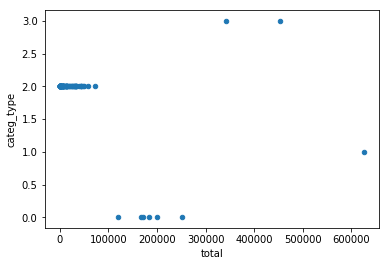

In [33]:
categ_types['total'] = categ_types.iloc[:, 1:12].sum(axis=1)
categ_types.plot.scatter(x='total', y='categ_type')